# SVI Approach

In [245]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pyro.distributions.constraints as constraints
from collections import defaultdict
import matplotlib.pyplot as plt
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
from pyro.infer import config_enumerate
from pyro import poutine

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [559]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch

from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints


def model(data):
    # Global variables.
    weights = pyro.param('weights', torch.FloatTensor([0.5]),
                         constraint=constraints.unit_interval)
    scales = pyro.param('scales', torch.tensor([[[1., 0.], 
                                                 [0., 2.]], 
                                                [[3., 0.], 
                                                 [0., 4.]]]), 
                        constraint=constraints.positive)
    locs = pyro.param('locs', torch.tensor([[1., 2.], 
                                            [3., 4.]]))

    with pyro.plate('data', data.size(0)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)

        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)

def full_guide(data):
    with pyro.plate('data', data.size(0)):
        # Local variables.
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={"enumerate": "sequential"})


def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*4), constraint=constraints.positive)

    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi


def get_samples(rates=[0.3, 0.7], means=[[0., 5.],[5., 0.]],
                covariance=torch.tensor([[1., 0.], [0., 1.]]), num_samples=500):

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor(means[0])
    sig1 = covariance

    mu2 = torch.tensor(means[1])
    sig2 = covariance

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(int(num_samples*rates[0]))]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(int(num_samples-num_samples*rates[0]))]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2)))
    return data

def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    plt.show()

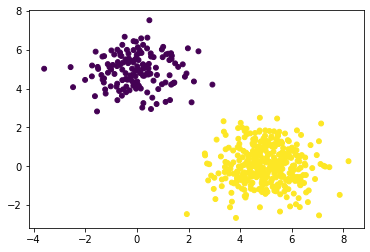

locs: tensor([[1.1000, 1.9000],
        [3.1000, 3.9000]], requires_grad=True)
scales: tensor([[[1.1052, 0.0000],
         [0.0000, 2.2103]],

        [[3.3155, 0.0000],
         [0.0000, 4.4207]]], grad_fn=<AddBackward0>)
weights = tensor([0.5000], grad_fn=<ClampBackward1>)


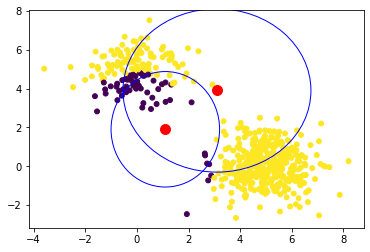

locs: tensor([[2.6481, 2.3570],
        [3.9654, 1.2458]], requires_grad=True)
scales: tensor([[[5.0562, 0.0000],
         [0.0000, 6.6620]],

        [[5.3432, 0.0000],
         [0.0000, 5.1466]]], grad_fn=<AddBackward0>)
weights = tensor([0.7115], grad_fn=<ClampBackward1>)


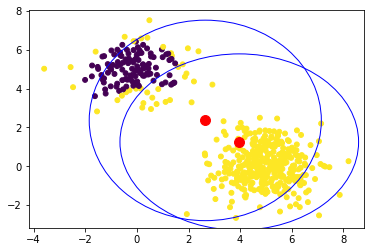

locs: tensor([[1.3336, 4.5232],
        [5.0076, 0.0320]], requires_grad=True)
scales: tensor([[[5.6076, 0.0000],
         [0.0000, 2.5606]],

        [[0.9867, 0.0000],
         [0.0000, 0.9329]]], grad_fn=<AddBackward0>)
weights = tensor([0.6696], grad_fn=<ClampBackward1>)


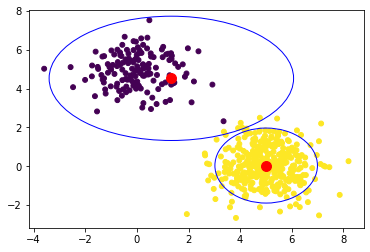

locs: tensor([[0.1058, 4.8795],
        [5.0061, 0.0582]], requires_grad=True)
scales: tensor([[[2.1527, 0.0000],
         [0.0000, 0.9742]],

        [[0.9861, 0.0000],
         [0.0000, 0.9589]]], grad_fn=<AddBackward0>)
weights = tensor([0.6968], grad_fn=<ClampBackward1>)


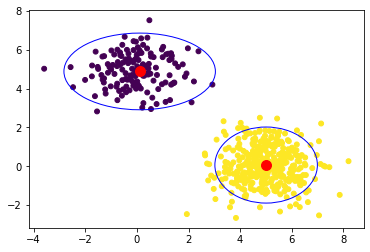

In [560]:
pyro.enable_validation(True)
pyro.set_rng_seed(42)

# Create our model with a fixed number of components
K = 2

data = get_samples()

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
global_guide = config_enumerate(global_guide, 'parallel')
_, svi = initialize(data)

true_colors = [0] * 150 + [1] * 350
plot(data, colors=true_colors, figname='pyro_init.png')

for i in range(151):
    svi.step(data)

    if i % 50 == 0:
        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')

        print("locs: {}".format(locs))
        print("scales: {}".format(scales))
        print('weights = {}'.format(weights))

        # todo plot data and estimates
        assignments = np.uint8(np.round(assignment_probs.data))
        plot(data, locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))

In [561]:
torch.zeros((data.shape[0],2,2)).shape

torch.Size([500, 2, 2])

# AVI Approach

In [562]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [563]:
assert pyro.__version__.startswith('1.8.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
#smoke_test = 'CI' in os.environ
device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
from torch.distributions.utils import (_sum_rightmost, broadcast_all,
                                       lazy_property, tril_matrix_to_vec,
                                       vec_to_tril_matrix)

In [832]:
def make_pd_mat(size, tensor_of_vectors):
    x = vec_to_tril_matrix(tensor_of_vectors)
    for idx in range(size):
        x[:, idx, idx] = torch.exp(x[:, idx, idx])
    z_scale = torch.bmm(x, x.transpose(1, 2))
    return z_scale

In [906]:
import torch.nn.functional as F
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, n_variables, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        self.n_variables = n_variables
        self.input_dim = input_dim
        
        # setup the layers
        # mu layers
        self.fc1 = nn.Linear(input_dim[0]*input_dim[1], hidden_dim*3)
        self.hidden_mu_1_1 = nn.Linear(hidden_dim*3, hidden_dim*2)
        self.hidden_mu_1_2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_mu_1 = nn.Linear(hidden_dim, n_variables)
        self.hidden_mu_2_1 = nn.Linear(hidden_dim*3, hidden_dim*2)
        self.hidden_mu_2_2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_mu_2 = nn.Linear(hidden_dim, n_variables)
        # sigma layers
        val = int((n_variables**2 + n_variables) / 2)
        self.hidden_sigma_1 = nn.Linear(hidden_dim*3, hidden_dim*2)
        self.hidden_sigma_2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_sigma_1 = nn.Linear(hidden_dim, val)
        self.fc_sigma_2 = nn.Linear(hidden_dim, val)
        
        # rate layers
        self.hidden_rate_1 = nn.Linear(hidden_dim*3, hidden_dim*2)
        self.hidden_rate_2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_rate = nn.Linear(hidden_dim, n_variables)

    def forward(self, x):
        # then compute the hidden units
        hidden = self.fc1(x.reshape(x.shape[0], self.input_dim[0] * self.input_dim[1]))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x n_variables
        # layers for calculating loc
        z_loc_1 = self.hidden_mu_1_1(hidden)
        z_loc_1 = self.hidden_mu_1_2(z_loc_1)
        z_loc_1 = self.fc_mu_1(z_loc_1)
        z_loc_2 = self.hidden_mu_2_1(hidden)
        z_loc_2 = self.hidden_mu_2_2(z_loc_2)
        z_loc_2 = self.fc_mu_2(z_loc_2)
        
        # layers for calc scale
        A = self.hidden_sigma_1(hidden)
        A = self.hidden_sigma_2(A)
        A_1_vect = self.fc_sigma_1(A)
        A_1 = vec_to_tril_matrix(A_1_vect)
        z_scale_1 = torch.bmm(A_1, A_1.transpose(1, 2))
        z_scale_1.add_(torch.eye(self.n_variables)*1e-4)
        A_2_vect = self.fc_sigma_2(A)
        A_2 = vec_to_tril_matrix(A_2_vect)
        z_scale_2 = torch.bmm(A_2, A_2.transpose(1, 2))
        z_scale_2.add_(torch.eye(self.n_variables)*1e-4)
        
        # layer for rate
        rate = F.sigmoid(self.hidden_rate_1(hidden))
        rate = F.sigmoid(self.hidden_rate_2(rate))
        rate = F.sigmoid(self.fc_rate(rate))*5
        return z_loc_1, z_scale_1, z_loc_2, z_scale_2, rate


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        n_variables=2, hidden_dim=250, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(n_variables, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.n_variables = n_variables
        
    """   
    def model(data):
        # Global variables.
        weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
        scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]]), constraint=constraints.positive)
        locs = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.]]))

        with pyro.plate('data', data.size(0)):
            # Local variables
            assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
            pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)

    def full_guide(data):
        with pyro.plate('data', data.size(0)):
            # Local variables.
            assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                          constraint=constraints.unit_interval)
            pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={"enumerate": "sequential"})
    """     
    # define the model p(x|z)p(z)
    def model(self, sigma, x):

        ### setup hyperparameters for prior p(z) ###
        
        # array of mean priors for each dist in mixture
        # dimension = n_samples x n_variables x n_mixtures
        μ_loc_prior = (-25-25)*torch.rand((x.shape[0],2,2), dtype=x.dtype, device=x.device)+25

        # array of scale priors for each dist in mixture
        # dimension = n_samples x n_variables x n_variables x n_mixtures
        μ_scale_prior = torch.eye(x[0].shape[1]).reshape(
            (2, 2, 1)).repeat(1,1,2).repeat(x.shape[0], 1, 1, 1)
        
        # array of rate priors for each dist in mixture
        # dimension = n_samples x n_mixtures
        rate_prior = torch.ones((x.shape[0], 2)) / 2

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # sample from prior (value will be sampled by guide when computing the ELBO
            # μ and σ are matrices with prior on each dist in the mixture
            μ_1 = pyro.sample("latent_mu_1_{}".format(i), 
                             dist.MultivariateNormal(μ_loc_prior[i,:,0], 
                                                     μ_scale_prior[i,:,:,0]))
            μ_2 = pyro.sample("latent_mu_2_{}".format(i), 
                             dist.MultivariateNormal(μ_loc_prior[i,:,1], 
                                                     μ_scale_prior[i,:,:,1])) 
            # rate is sampled from a direchlete
            rate = pyro.sample('weights_{}'.format(i), dist.Dirichlet(rate_prior[i,:]))

            # sigma is shared
            Σ = sigma[i]
            
            with pyro.plate("data_loop_{}".format(i), x[i].shape[0]):
                assignment = pyro.sample("assignment_{}".format(i), 
                                    dist.Bernoulli(torch.ones(x[i,:,:].shape[0]) * rate[0][0])).to(torch.int64)
                μ_both = torch.cat((μ_1, μ_2))
                pyro.sample("obs_{}".format(i), 
                            dist.MultivariateNormal(
                                μ_both[assignment], Σ),
                                obs=x[i, :, :])
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, sigma, x):
        
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc_1, z_scale_1, z_loc_2, z_scale_2, r = self.encoder.forward(x[i].unsqueeze(0))

            # sample the latent variables
            μ_1 = pyro.sample("latent_mu_1_{}".format(i), 
                            dist.MultivariateNormal(z_loc_1, z_scale_1))
            μ_2 = pyro.sample("latent_mu_2_{}".format(i), 
                            dist.MultivariateNormal(z_loc_2, z_scale_2))

            rate = pyro.sample("weights_{}".format(i), dist.Dirichlet(r))
#             print("NN Parameters:")
#             print(r)
#             print("Categorical frequency:")
#             print(rate)

In [907]:
(-50-50)*torch.rand((x.shape[0],2,2), dtype=x.dtype, device=x.device)+50

tensor([[[ 49.3737, -20.9226],
         [-28.2959,  36.5855]],

        [[-18.3153,  14.2514],
         [ -4.2498, -42.9547]],

        [[ 47.0181, -21.0842],
         [-42.4597,  20.3594]],

        [[ -1.2075, -24.3150],
         [-23.0893,   1.3078]],

        [[ 48.0859,   8.4000],
         [ -2.1058, -28.8975]]])

In [908]:
X = []
means = []
rates = []
for sample in range(5):
    covariance = torch.tensor([[1., 0.], [0., 1.]])
    rate_0 = np.random.choice(range(1,100))/100
    mean_0 = np.random.uniform(-50,-25, 2).tolist()
    mean_1 = np.random.uniform(25,50, 2).tolist()
    x_i = get_samples(rates=[float(rate_0), float(1-rate_0)], means=[mean_0,mean_1], 
                      covariance = covariance, num_samples=500)
    means.append([mean_0, mean_1])
    rates.append(rate_0)
    X.append([x_i, covariance])

In [909]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = (500, 2)
mu = stats.norm.rvs(size=input_dim)

# setup the VAE
vae = VAE(use_cuda=False, input_dim=input_dim, n_variables=2)

adam_args = {"lr": 1e-5}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=TraceEnum_ELBO())
train_loader = DataLoader(X, batch_size=250, shuffle=True,
     num_workers=1, pin_memory=False, drop_last=False)

train_elbo = []

for epoch in range(50):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    print("Epoch: ", epoch, end = "\r")
    for x, sigma in train_loader:
        # x = x.cuda()
        epoch_loss += svi.step(sigma, x)

    # report training diagnostics
    if not epoch % 2:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

Guessed max_plate_nesting = 1


[epoch 000]  average training loss: 729679.0000
[epoch 002]  average training loss: 735944.3000
[epoch 004]  average training loss: 699482.8000
[epoch 006]  average training loss: 603500.4500
[epoch 008]  average training loss: 619416.8500
[epoch 010]  average training loss: 601937.4500
[epoch 012]  average training loss: 591123.6000
[epoch 014]  average training loss: 567115.8000
[epoch 016]  average training loss: 568903.5000
[epoch 018]  average training loss: 560078.3000
[epoch 020]  average training loss: 561127.0500
[epoch 022]  average training loss: 547460.3500
[epoch 024]  average training loss: 536180.1000
[epoch 026]  average training loss: 535910.8000
[epoch 028]  average training loss: 537306.1000
[epoch 030]  average training loss: 528958.2000
[epoch 032]  average training loss: 527439.5500
[epoch 034]  average training loss: 542625.2500
[epoch 036]  average training loss: 568860.3000
[epoch 038]  average training loss: 534813.0500
[epoch 040]  average training loss: 5346

Text(0, 0.5, 'ELBO loss')

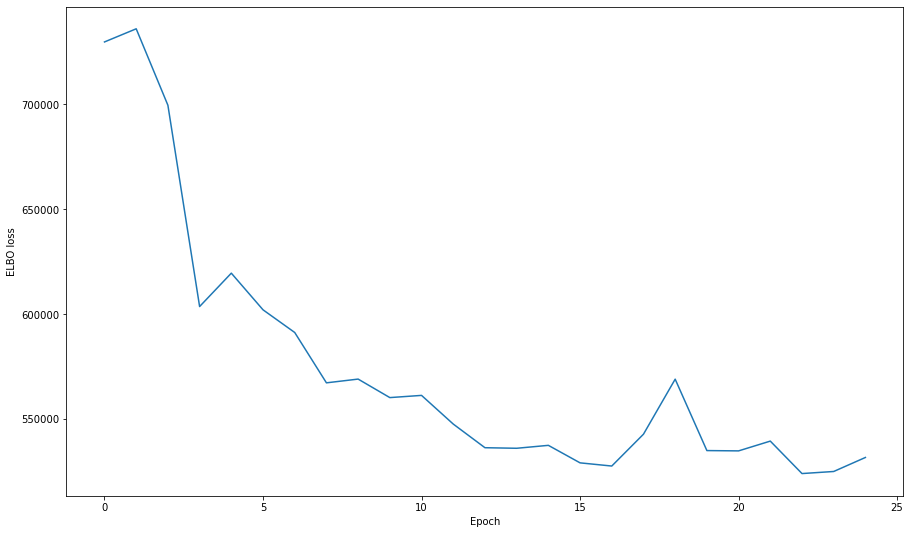

In [910]:
plt.figure(figsize=(15, 9))
plt.plot([i for i in range(len(train_elbo))], train_elbo)
plt.xlabel("Epoch")
plt.ylabel("ELBO loss")

In [911]:
for idx in range(10):
    print("Results for idx {}".format(idx))
    X[idx][0].shape
    mean_pred_1, s, mean_pred_2, s2, r = vae.encoder.forward(X[idx][0].unsqueeze(0))
    mean_act = means[idx]
    rate_act = rates[idx]
    print("Predicted means: {}.".format([mean_pred_1, mean_pred_2]))
    print("Actual means: {}.".format(mean_act))
    print("Predicted rate: {}.".format(r))
    print("Actual rate: {}.".format(rate_act))
    print("============================================")
    print()
    print()

Results for idx 0
Predicted means: [tensor([[-5.4689, -4.4934]], grad_fn=<AddmmBackward0>), tensor([[-4.6464, -5.5363]], grad_fn=<AddmmBackward0>)].
Actual means: [[-26.44191283385099, -38.64908262051439], [26.552941438835425, 31.544070309547365]].
Predicted rate: tensor([[2.8593, 2.4719]], grad_fn=<MulBackward0>).
Actual rate: 0.53.


Results for idx 1
Predicted means: [tensor([[27.2526, 24.4495]], grad_fn=<AddmmBackward0>), tensor([[26.4718, 24.2419]], grad_fn=<AddmmBackward0>)].
Actual means: [[-35.29192802259998, -42.42953978536641], [46.64293645017082, 46.64693138807237]].
Predicted rate: tensor([[2.9479, 2.4116]], grad_fn=<MulBackward0>).
Actual rate: 0.26.


Results for idx 2
Predicted means: [tensor([[ 8.0656, 11.0313]], grad_fn=<AddmmBackward0>), tensor([[ 6.5821, 12.7322]], grad_fn=<AddmmBackward0>)].
Actual means: [[-46.52524748470285, -42.79013550262089], [39.028193093895744, 48.098829083376046]].
Predicted rate: tensor([[2.8320, 2.4697]], grad_fn=<MulBackward0>).
Actual ra

IndexError: list index out of range